# Analisi disastri aerei

Data type info
- date: data dell'incidente
- type: tipo del veivolo
- registration: codice di registrazione del veivolo
- operator: operatore del veivolo
- fatalities: numero di morti
- location: luogo dell'incidente
- country: nazione dell'incidente
- cat: categoria dell'incidente come descritto dal ASN


### Import

In [577]:
#to bypass the warning message from pyarrow (cause is becaming a required package for pandas, but not necessary now)
import warnings
warnings.filterwarnings("ignore", "\nPyarrow", DeprecationWarning)

In [578]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import re
import math
import geopandas as gpd

%matplotlib inline
plt.figure(figsize=(14,10))

<Figure size 1400x1000 with 0 Axes>

<Figure size 1400x1000 with 0 Axes>

In [579]:
print(plt.get_backend())

module://matplotlib_inline.backend_inline


### Functions RIUTILIZZABILI

In [580]:
def check_str_special(s, pattern):
    '''
    Return True if a string contains special pattern
    False in other cases
    '''

    if re.search(pattern, s):
        return True
    return False

In [581]:
def clean_str_from_pattern(str_to_check ,patt, repl=''):
    ''''
    Search a pattern in a string
    If it's found it's replaced 
    Return the string corrected and a boolean if the pattern was found or not
    '''
    if patt in str_to_check:
        str_correct = str_to_check.replace(patt, repl).strip()
        return str_correct
    else:   
        return str_to_check

In [582]:
def modify_str_unknown(string_unk, nan_in_unk=False):
    '''
    Modify the unknown string
    If is NaN return NaN (if the Nan needs to converted in 'unkwown' put nan_in_unk=True)
    If is '?' return 'unknown'
    If find the pattern 'nkn' return 'unknown'
    '''
    pattern = r'nkn'
    if string_unk is np.nan:
        if nan_in_unk:
            string_unk = 'unknown'
        return string_unk
    if check_str_special(string_unk, pattern):
        string_unk = 'unknown'
    if string_unk == '?':
        string_unk = 'unknown'    
    
    return string_unk

In [583]:
def check_str_in_df (df, col, pattern):
    '''
    Check if the values in a df column contain special pattern
    Clean df from NaN values
    Check if the pattern is present in the string 
    Print how many times the pattern is found
    Save the indexes of those rows
    Print the rows with the pattern
    Print the unique values of the column
    Return True if the pattern is found
    '''
    find = False
    df_notna= df[col].dropna()
    mask = df_notna.str.contains(pattern)
    print('Positive results of the search = ' ,format(mask.sum()))
    if mask.sum()>0:
        find = True
    index_search = df_notna[mask].index
    df_search = df.loc[index_search]
    display(df_search)
    unique_values = list(df_search[col].unique())
    print('The values found are:\n', unique_values)
    
    return find

## Data Preparation
<a id='data_preparation'></a>

### File overview

In [584]:
file = "aviation-accidents.csv"
#df =  pd.read_csv(file, encoding='latin1')
df = pd.read_csv(file, encoding='utf-8')

In [585]:
df.shape

(23967, 9)

In [586]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23967 entries, 0 to 23966
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          23967 non-null  object
 1   type          23967 non-null  object
 2   registration  22419 non-null  object
 3   operator      23963 non-null  object
 4   fatalities    20029 non-null  object
 5   location      23019 non-null  object
 6   country       23967 non-null  object
 7   cat           23967 non-null  object
 8   year          23967 non-null  object
dtypes: object(9)
memory usage: 1.6+ MB


,date,type,registration,operator,fatalities,location,country,cat,year
0,date unk.,Antonov An-12B,T-1206,Indonesian AF,NaN,NaN,Unknown country,U1,unknown
1,date unk.,Antonov An-12B,T-1204,Indonesian AF,NaN,NaN,Unknown country,U1,unknown
2,date unk.,Antonov An-12B,T-1201,Indonesian AF,NaN,NaN,Unknown country,U1,unknown
3,date unk.,Antonov An-12BK,NaN,Soviet AF,NaN,Tiksi Airport (IKS),Russia,A1,unknown
4,date unk.,Antonov An-12BP,CCCP-11815,Soviet AF,0,Massawa Airport ...,Eritrea,A1,unknown


In [587]:
df.describe()

,date,type,registration,operator,fatalities,location,country,cat,year
count,23967,23967,22419,23963,20029,23019,23967,23967,23967
unique,15079,3201,21962,6017,369,14608,232,11,106
top,10-MAY-1940,Douglas C-47A (DC-3),LZ-...,USAAF,0,unknown,USA,A1,1944
freq,171,1916,13,2604,10713,272,4377,17424,1505


### Dates
<a id='dates'></a>

In [588]:
count_values = df['date'].value_counts()
display(count_values)


date
10-MAY-1940    171
date unk.       61
24-MAR-1945     50
06-JUN-1944     41
17-SEP-1944     35
              ... 
04-MAY-1971      1
06-MAY-1971      1
07-MAY-1971      1
08-MAY-1971      1
15-MAY-2023      1
Name: count, Length: 15079, dtype: int64

In [589]:
#df with only record dates unkwown
date_unknown = df[df['date'] == 'date unk.']  
display(date_unknown)

,date,type,registration,operator,fatalities,location,country,cat,year
0,date unk.,Antonov An-12B,T-1206,Indonesian AF,NaN,NaN,Unknown country,U1,unknown
1,date unk.,Antonov An-12B,T-1204,Indonesian AF,NaN,NaN,Unknown country,U1,unknown
2,date unk.,Antonov An-12B,T-1201,Indonesian AF,NaN,NaN,Unknown country,U1,unknown
3,date unk.,Antonov An-12BK,NaN,Soviet AF,NaN,Tiksi Airport (IKS),Russia,A1,unknown
4,date unk.,Antonov An-12BP,CCCP-11815,Soviet AF,0,Massawa Airport ...,Eritrea,A1,unknown
...,...,...,...,...,...,...,...,...,...
56,date unk.,Lisunov Li-2,CCCP-63916,"Aeroflot, Yakutsk",NaN,near Tiksi,Russia,A1,unknown
57,date unk.,Lisunov Li-2F,39,Polish AF,0,NaN,Poland,O1,unknown
58,date unk.,SNCASO S.O.94R Corse II,56.S.17,French Navy,0,within France,France,A1,unknown
59,date unk.,Super Avia 14,LZ-ILF,Balkan Bulgarian,NaN,Provadia,Bulgaria,A1,unknown


In [590]:
date_unknown.isna().sum()  #check for NaN values

date             0
type             0
registration     3
operator         0
fatalities      36
location        28
country          0
cat              0
year             0
dtype: int64

Values "date unk." considered Nan, and in these records there are lots of Nan in other columns, so it's good to clean the dataset and drop these records

Do a search [watch notes](#notes)

In [591]:
def change_unknown_date_in_nan(date):
    '''
    Function to change the date unk. to NaN
    '''
    if str(date) == 'date unk.':
        return np.nan
    return date

In [592]:
def convert_date_to_datetime(date):
    '''
    Convert a string to a date object
    if not pssible return the original string (es. ??-???-YYYY, Nan, etc.)
    '''
    date_str = str(date)
    try:
        date_datetime = pd.to_datetime(date_str).date()
        return date_datetime
    except:
        return date_str

In [593]:
def get_day_month_year(date):
    '''
    Separate the date in day, month and year
    Return nan where there's no value for that information
    '''
    if isinstance(date, datetime.date):
        d = date.day
        m = date.month
        y = date.year
        weekday = date.isoweekday()    #monday is 1, sunday is 7
        
    elif date is np.nan:
        d, m, y, weekday = np.nan, np.nan, np.nan, np.nan
        
    elif isinstance(date, str):
        d, m, y = date.split('-')
        try:
            d = int(d)
        except:
            d = np.nan
        try:
            m = datetime.datetime.strptime(m, '%b').month
        except:
            m = np.nan
        try: 
            y = int(y)
        except:
            y = np.nan
            
        weekday = np.nan
    return (y, m, d, weekday)    

In [594]:
#apply the manipulations to the date column
df['date'] = df['date'].apply(change_unknown_date_in_nan)                                           #change date unk. to NaN
df['date'] = df['date'].apply(convert_date_to_datetime)                                             #convert to datetime type
df[['year', 'month', 'day', 'weekday']] = df['date'].apply(get_day_month_year).apply(pd.Series)     #split the date in year, month and day
columns_order = list(df.columns)
columns_order = columns_order[:-3] + ['month', 'day', 'weekday']
df = df.reindex(columns=columns_order)                                                              #reorder the columns


### Type

In [595]:
df['type'].value_counts()

type
Douglas C-47A (DC-3)        1916
Douglas C-47 (DC-3)          669
Douglas C-47B (DC-3)         592
Curtiss C-46A                564
Junkers Ju-52/3m             471
                            ... 
Boeing 737-3Z6                 1
Boeing 747-230B (M)            1
Lockheed P2V-2N Neptune        1
Ilyushin Il-76MD Adnan-1       1
Boeing 777-233LR               1
Name: count, Length: 3201, dtype: int64

In [596]:
#apply the function to the operator column to decode the special characters
df['type'] = df['type'].apply(clean_str_special_w_dict)

In [597]:
unique_type = list(df['type'].unique())  #unique operators
uniq_type_df = pd.DataFrame(unique_type)

In [598]:
#check if the types contain special characters
pat = r'\u00C3'
check_str_in_df(uniq_type_df, 0, pat)

Positive results of the search =  11


,0
45,BlÃ©riot 155
90,LiorÃ© et Olivier 212
92,LiorÃ© et Olivier 213
129,LiorÃ©-et-Olivier H.242/1
287,LiorÃ©-et-Olivier H.246.1
397,LiorÃ©-et-Olivier H.246
408,LatÃ©coÃ¨re 631
1237,FMA IA 50 GuaranÃ­ II
1331,AÃ©rospatiale SN.600 Corvette
1645,AÃ©rospatiale SN.601 Corvette


The values found are:
 ['BlÃ©riot 155', 'LiorÃ© et Olivier 212', 'LiorÃ© et Olivier 213', 'LiorÃ©-et-Olivier H.242/1', 'LiorÃ©-et-Olivier H.246.1', 'LiorÃ©-et-Olivier H.246', 'LatÃ©coÃ¨re 631', 'FMA IA 50 GuaranÃ\xad II', 'AÃ©rospatiale SN.600 Corvette', 'AÃ©rospatiale SN.601 Corvette', 'Nord 262D-51 FrÃ©gate']


True

In [599]:
df['type'].isna().sum()

0

### Registration

In [600]:
df['registration'].isna().sum()

1548

In [601]:
# nan in the records where the registration is nan
reg_nan = df[df['registration'].isna()]
reg_nan.isna().sum()

date               3
type               0
registration    1548
operator           2
fatalities       275
location         101
country            0
cat                0
year               3
month             35
day               51
weekday           51
dtype: int64

In [602]:
#apply the function to the operator column to decode the special characters
df['registration'] = df['registration'].apply(clean_str_special_w_dict)

In [603]:
unique_reg = list(df['registration'].unique())  #unique operators
uniq_reg_df = pd.DataFrame(unique_reg)
#check if the types contain special characters
pat = r'\u00C3'
check_str_in_df(uniq_reg_df, 0, pat)

Positive results of the search =  0


,0


The values found are:
 []


False

### Operator
<a id='operator'></a>

In [604]:
df['operator'].isna().sum()

4

In [605]:
#apply the function to the operator column to modify the unknown operators e nan
df['operator'] = df['operator'].apply(lambda x: modify_str_unknown(x, True))

In [606]:
df['operator'] = df['operator'].apply(lambda x: str(x).encode('latin1', 'ignore').decode('utf-8', 'ignore'))

In [607]:
unique_operators = list(df['operator'].unique())  #unique operators
unique_operators

['Indonesian AF',
 'Soviet AF',
 'GUSMP, Directorate of Polar Aviation',
 'Aeroflot',
 'Russian AF',
 'Sin Sad Airlines',
 'PZL-Mielec',
 'Privredna Avijacija Osijek',
 'Aeroflot, Azerbaijan',
 'Indian AF',
 'Antonov Design Bureau',
 'Balkan Bulgarian',
 'unknown',
 'Somalian Aeronautical Corps',
 'MD Air Services',
 'Enterprise General M.Forrest',
 'Bush Pilots',
 'St. Lucia Airways',
 'Mauritanian AF',
 'Jenair',
 'Bordeaux Aviation',
 'Aero Servicios Caicara',
 'Aviacsa',
 'Harbor Airlines',
 'Aviazur',
 'Surinam Air Force',
 'USAAF',
 'SAHSA',
 'Peruvian AF',
 'JetPet',
 'Ilyushin',
 'Yemen AF',
 'Ukraine Air Force',
 'Libyan Arab Rep. Air Force',
 'Atlantic Airlines',
 'Aeroflot, Yakutsk',
 'Polish AF',
 'French Navy',
 'Weasua Air Transport',
 'Caproni',
 'RAF',
 'Handley Page Transport',
 'Aeromarine Airways',
 'HP Indo-Burmese Transport',
 'SNETA',
 'Chinese Government',
 'Grands Express Aériens',
 'Air Union',
 'Compagnie Aérienne Française',
 'SGTA',
 'Imperial Airways',
 'De

In [608]:
#check if there are operators unknownk, and are written all in the same way
check_str_in_df(df, 'operator', r'nkn')

Positive results of the search =  189


,date,type,registration,operator,fatalities,location,country,cat,year,month,day,weekday
23,NaT,BN-2A Islander,HP-556XI,unknown,NaN,NaN,Unknown country,U1,NaN,NaN,NaN,NaN
28,NaT,BN-2A-21 Islander,F-ODHO,unknown,NaN,NaN,Unknown country,U1,NaN,NaN,NaN,NaN
35,NaT,BN-2A-8 Islander,TZ-ASC,unknown,0,NaN,Unknown country,U1,NaN,NaN,NaN,NaN
40,NaT,Douglas C-47A (DC-3),HK-1505,unknown,0,within Bahamas,Bahamas,A1,NaN,NaN,NaN,NaN
55,NaT,Lisunov Li-2,NaN,unknown,NaN,near Ugulan,Russia,A1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
23739,2021-12-30,Beech 300 Super King Air,TG-MAM,unknown,0,Rio Dulce-Las Ve...,Guatemala,A1,2021.0,12.0,30.0,4.0
23812,2022-05-28,Beech B200 King Air,ZS-PTE,unknown,0,near Lynedoch Private...,South Africa,A1,2022.0,5.0,28.0,6.0
23853,2022-08-31,Cessna 208 Caravan,NaN,unknown,0,near Abu Dhabi-Bateen...,U.A.E.,A1,2022.0,8.0,31.0,3.0
23918,2023-01-27,Ilyushin Il-18D,TL-KBR,unknown,NaN,Al-Khadim Air Base,Libya,O1,2023.0,1.0,27.0,5.0


The values found are:
 ['unknown']


True

### Fatalities
<a id='fatalities'></a>

In [609]:
df['fatalities'].isna().sum()

3938

In [610]:
def convert_fat_to_int(value):
    '''
    Check if a value is not an integer
    If is Nan return Nan
    If is string split with + and spaces (because formatted as 'x+y')
    Sum the integer values in the list
    Return the integer value
    '''
    try:
        int(value)
    except:
        if value is np.nan:
            return np.nan
        else:
            values = re.split(r'\+|\s', value)
            for i in range(len(values)):
                if values[i].isdigit():
                    values[i] = int(values[i])
                else:
                    values[i] = np.nan
            values = [x for x in values if not isinstance(x, type(np.nan))]
            value = sum(values)

    return int(value)

In [611]:
#convert to int the fatalities column also the ones with the + sign
df["fatalities"] = df['fatalities'].apply(convert_fat_to_int)

### Location

In [612]:
df['location'].value_counts(dropna=False)

location
NaN                         948
unknown                     272
Havana-JosÃ© Mar...         106
Miami Internatio...          71
Beirut Internati...          48
                           ... 
Ciudad Trujillo-...           1
RÃ­o Cuarto Airp...           1
near Leeming RAF Station      1
Taipeh                        1
Hohn Air Base                 1
Name: count, Length: 14609, dtype: int64

In [613]:
df['location'] = df['location'].apply(lambda x: str(x).encode('latin1','ignore').decode('utf-8', 'ignore'))
df['location'] = df['location'].apply(lambda x: clean_str_from_pattern(x, "?", ''))
#apply the function to the location column to modify the unknown operators
df['location'] = df['location'].apply(lambda x: modify_str_unknown(x, True))

In [614]:
location_unique = list(df['location'].dropna().unique())
location_unique

['nan',
 'Tiksi Airport (IKS)',
 'Massawa Airport ...',
 'unknown',
 'Chita region',
 'Orenburg Air Base',
 'Belgorod Airport...',
 'Wadi Bu al Hashm',
 'Mielec',
 'Kalaikunda Air F...',
 'Sofia-Vrazhdebna...',
 'Nassau Internati...',
 'Charles Prince',
 'Paphos Internati...',
 'Toluca',
 'Nouméa',
 'within Bahamas',
 'Trujillo-Capiro ...',
 'Nairobi-Wilson A...',
 'near Tukalan River',
 'Ice Station Koms...',
 'Riga-Spilve Airp...',
 'Novokuznetsk Air...',
 'Shadrinsk Air Base',
 "Sana'a Internati...",
 'Uzyn Air Base',
 'La Ceiba',
 'near Ugulan',
 'near Tiksi',
 'within France',
 'Provadia',
 'Monrovia-Sprigg ...',
 'Verona',
 'near Felixtowe RNAS',
 'Acadia Siding, C...',
 'near El Shereik',
 'Östanå',
 'Golders Green',
 'Havana harbour',
 'Meerut',
 'Lago Maggiore',
 'near Calais [The Engl...',
 'Evere Airfield',
 'Berck-sur-Mer',
 'near Senlis',
 'near Beijing-Nanyuan ...',
 'Thieuloy-Saint-A...',
 'near Havana, Cuba',
 'Monsures, Somme',
 'near Étaples',
 'Poix',
 'near Valencie

In [615]:
check_str_in_df(df, 'location', r'\?')

Positive results of the search =  0


,date,type,registration,operator,fatalities,location,country,cat,year,month,day,weekday


The values found are:
 []


False

In [616]:
#check if there are locations unknown all written in the same way
check_str_in_df(df, 'location', r'nkn')

Positive results of the search =  329


,date,type,registration,operator,fatalities,location,country,cat,year,month,day,weekday
6,NaT,Antonov An-2,CCCP-N574,"GUSMP, Directorate of Polar Aviation",NaN,unknown,Russia,A1,NaN,NaN,NaN,NaN
41,NaT,Douglas C-47D (DC-3),43-49023,USAAF,NaN,unknown,Unknown country,U1,NaN,NaN,NaN,NaN
43,NaT,Fairchild SA227-DC Metro 23 (C-26B),341,Peruvian AF,NaN,unknown,Peru,A1,NaN,NaN,NaN,NaN
337,??-MAR-1937,Douglas DC-2-115B,EC-AAY,LAPE,NaN,unknown,Unknown country,U1,1937.0,3.0,NaN,NaN
797,1940-10-04,DH.95 Flamingo,T5357,RAF,NaN,unknown,Unknown country,A1,1940.0,10.0,4.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
21081,2009-02-24,Lockheed C-130H Hercules,SU-BAC/1272,Egyptian AF,0.0,unknown,Egypt,A1,2009.0,2.0,24.0,2.0
21882,??-MAY-2013,Lockheed C-130H Hercules,T.10-02,Spanish AF,0.0,unknown,Spain,U1,2013.0,5.0,NaN,NaN
21920,2013-07-25,Canadair Challenger 601,N163WG,Blue Water Aviation,0.0,unknown,USA,A1,2013.0,7.0,25.0,4.0
22565,2016-06-14,ATR 72-212A (ATR 72-600),PK-WGL,Wings Air,0.0,unknown,Indonesia,A2,2016.0,6.0,14.0,2.0


The values found are:
 ['unknown']


True

### Country

In [617]:
#apply the function to the location column to modify the unknown operators
df['country'] = df['country'].apply(lambda x: modify_str_unknown(x, True))
#apply the function to the country column to decode the special characters
df['country'] = df['country'].apply(lambda x: str(x).encode('latin1','ignore').decode('utf-8', 'ignore'))


country_unique = list(df['country'].dropna().unique())
country_unique

['unknown',
 'Russia',
 'Eritrea',
 'Libya',
 'Poland',
 'India',
 'Bulgaria',
 'Bahamas',
 'Zimbabwe',
 'Mauritania',
 'Cyprus',
 'Mexico',
 'New Caledonia',
 'Honduras',
 'Peru',
 'Kenya',
 'Antarctica',
 'Latvia',
 'Yemen',
 'Ukraine',
 'France',
 'Liberia',
 'Italy',
 'U.K.',
 'South Africa',
 'Sudan',
 'Sweden',
 'Cuba',
 'Belgium',
 'China',
 'Atlantic Ocean',
 'Netherlands',
 'Germany',
 'USA',
 'Iran',
 'Chile',
 'Israel',
 'Argentina',
 'P.N. Guinea',
 'Nicaragua',
 'Czech Rep.',
 'Dominican Rep.',
 'Brazil',
 'Mediterranean Sea',
 'Indonesia',
 'Egypt',
 'Bolivia',
 'Spain',
 'Australia',
 'Iraq',
 'Guatemala',
 'Malta',
 'Colombia',
 'Switzerland',
 'Austria',
 'Uganda',
 'Trinidad & Tobago',
 'Norway',
 'Greece',
 'Algeria',
 'Pakistan',
 'Panama',
 'Romania',
 'Morocco',
 'Pacific Ocean',
 'Hungary',
 'Jamaica',
 'Japan',
 'Canada',
 'Gambia',
 'Thailand',
 'Philippines',
 'Ecuador',
 'Puerto Rico',
 'Venezuela',
 'Mozambique',
 'Singapore',
 'Myanmar',
 'Djibouti',
 'Gibr

In [618]:
#check if there are countries unknown
check_str_in_df(df, 'country', r'nkn')

Positive results of the search =  857


,date,type,registration,operator,fatalities,location,country,cat,year,month,day,weekday
0,NaT,Antonov An-12B,T-1206,Indonesian AF,NaN,nan,unknown,U1,NaN,NaN,NaN,NaN
1,NaT,Antonov An-12B,T-1204,Indonesian AF,NaN,nan,unknown,U1,NaN,NaN,NaN,NaN
2,NaT,Antonov An-12B,T-1201,Indonesian AF,NaN,nan,unknown,U1,NaN,NaN,NaN,NaN
14,NaT,Antonov An-2R,YU-BFR,Privredna Avijacija Osijek,NaN,nan,unknown,U1,NaN,NaN,NaN,NaN
15,NaT,Antonov An-2T,CCCP-01196,"Aeroflot, Azerbaijan",0.0,nan,unknown,O1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
18802,??-???-1998,Lockheed KC-130F Hercules,149807,USMC,0.0,unknown,unknown,A1,1998.0,NaN,NaN,NaN
19044,2000-01-03,Beech 200 Super King Air,A2-AEZ,Kalahari Air Services & Charter,NaN,unknown,unknown,U1,2000.0,1.0,3.0,1.0
19075,??-FEB-2000,CASA C-212 Aviocar 200,N461CA,Sandair,0.0,nan,unknown,U1,2000.0,2.0,NaN,NaN
19806,2003-05-10,Antonov An-2R,UK-68038,Uzbekistan Airways,NaN,nan,unknown,A2,2003.0,5.0,10.0,6.0


The values found are:
 ['unknown']


True

### Category

In [619]:
df['cat'].value_counts(dropna=False)

cat
A1    17424
A2     2494
C1     1185
H2     1052
O1     1035
U1      571
C2       84
O2       65
H1       42
I2       12
I1        3
Name: count, dtype: int64

In [620]:
df['cat'].isna().sum()

0

## Data analysis

### for Operator

In [621]:
#create a dataframe to evaluete the operators with different parameters
op_df = pd.DataFrame()

#count the number of accidents for each operator
op_df['N_accidents'] = df['operator'].value_counts()  

#count the number of fatalities for each operator
op_df['N_fatalities'] = df.groupby(['operator'])['fatalities'].sum()

#calcularing the number of years in which the operator has been almost an accident
#op_df['N_years'] = df.groupby(['operator'])['year'].nunique()

For the operators with with a form: 'op1' separato 'op2'

With separators = ', opf', ', opb', ', op.for', ', lsf', ', owb', ', lst'

The choice is to account both the op1 and op2 for the accident and the fatalities

In [622]:
#define a function that divide the operators and add the new operators to the dataframe
#every operator divided need to be updated the number of accidents and fatalities from the separation

def divide_operator(df):
    '''
    Divide the operator in two parts
    Add the new operators to the dataframe
    Update the number of accidents and fatalities
    '''
    df_operator = df.copy()
    separators = [', opf', ', opb', ', op.for', ', lsf', ', owb', ', lst']  #separators to divide the operators
    
    for op in df_operator.index:
        separation = False
        n_dis = df_operator.loc[op]['N_accidents']
        n_fat = df_operator.loc[op]['N_fatalities']
        new_op = []
        for sep in separators:
            if sep in op:
                new_op = op.split(sep)
                new_op[1] = new_op[1].strip()
                separation = True
                break
                   
        for n_op in new_op:
            if n_op not in df_operator.index:
                df_operator.loc[n_op] = [n_dis, n_fat]
            elif n_op in df_operator.index:
                df_operator.loc[n_op] = [df_operator.loc[n_op]['N_accidents'] + n_dis, df_operator.loc[n_op]['N_fatalities'] + n_fat]
                
        if separation:
            df_operator.drop(op, inplace=True)
    
    return df_operator

In [623]:
op_df = divide_operator(op_df)
op_df.reset_index(inplace=True)

In [624]:
df_op_notna = df[df['operator'].notna()]

def calculate_years(op, df=df_op_notna):
    '''
    Calculate the number of years an operator has almost a accident
    Return the sum of years
    '''
    mask = df['operator'].str.contains(op)
    years = df[mask]['year'].nunique()
    return int(years)

In [625]:
op_df['N_years'] = op_df['operator'].apply(calculate_years)
#calculate the ratio between the number of fatalities and the number of accidents for each operator
op_df['Fat_dis_ratio'] = round(op_df['N_fatalities']/op_df['N_accidents'], 2)
op_df.set_index('operator', inplace=True)

C:\Users\Tia\AppData\Local\Temp\ipykernel_12516\567233830.py:8: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df['operator'].str.contains(op)


In [626]:
op_df

,N_accidents,N_fatalities,N_years,Fat_dis_ratio
operator,,,,
USAAF,2617.0,4717.0,7,1.80
USAF,1135.0,6000.0,69,5.29
RAF,935.0,2726.0,54,2.92
US Navy,745.0,2849.0,63,3.82
German AF,518.0,1247.0,34,2.41
...,...,...,...,...
Agricultural High School,1.0,0.0,1,0.00
Carib Air Transport,1.0,10.0,1,10.00
UN Development Programme,1.0,0.0,1,0.00


In [627]:
#create different lists for the operators with the highest values of the parameters: accidents, fatalities
most_dis = list(op_df.sort_values(by='N_accidents', ascending=False).index)
most_fat = list(op_df.sort_values(by='N_fatalities', ascending=False).index)

#create a list with the worst operators
worst_op = most_dis[:7] + most_fat[:7]
#remove duplicates
worst_op = list(set(worst_op))

In [628]:
worst_op

['US Navy',
 'Aeroflot',
 'USAAF',
 'USAF',
 'United Airlines',
 'private',
 'German AF',
 'Air France',
 'RAF',
 'American Airlines']

In [629]:
op_df.loc[worst_op]

,N_accidents,N_fatalities,N_years,Fat_dis_ratio
operator,,,,
US Navy,745.0,2849.0,63,3.82
Aeroflot,200.0,577.0,66,2.88
USAAF,2617.0,4717.0,7,1.80
USAF,1135.0,6000.0,69,5.29
United Airlines,102.0,2071.0,55,20.30
private,302.0,296.0,76,0.98
German AF,518.0,1247.0,34,2.41
Air France,143.0,1753.0,59,12.26
RAF,935.0,2726.0,54,2.92


Visualizations for the operators analysis

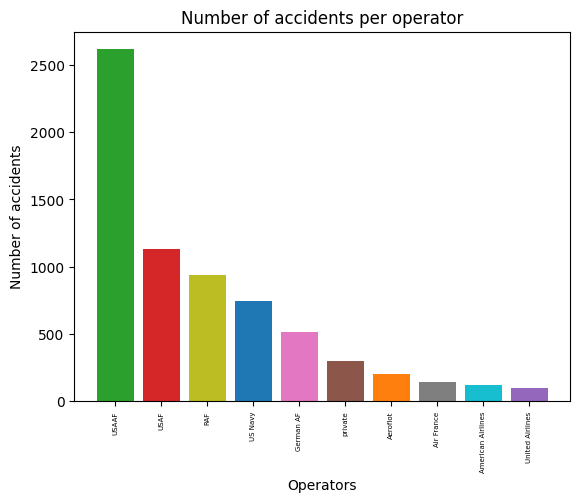

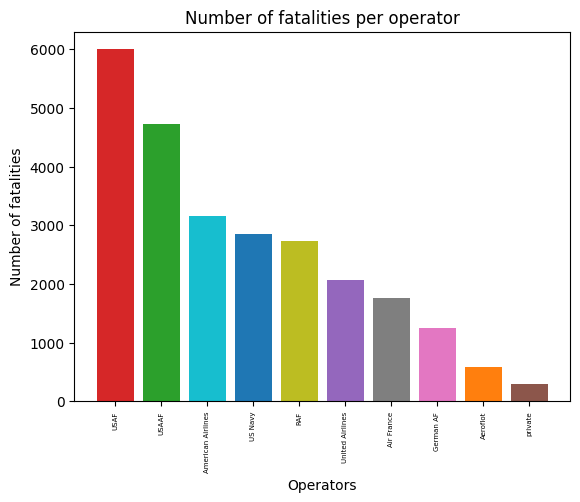

In [630]:
#Bar chart for the number of accidents and fatalities per operator (the worst)

labels = worst_op
colors_predefined = plt.rcParams['axes.prop_cycle'].by_key()['color']       #list of predefined colors
colors = dict(zip(labels, colors_predefined))                               #create a dictionary with the association operator-color

accidents = op_df[op_df.index.isin(labels)]['N_accidents']           #series with the number of accidents for each operator
fatalities = op_df[op_df.index.isin(labels)]['N_fatalities'].sort_values(ascending=False)       ##series with the number of accidents for each operator

op_order = list(accidents.index)                                         #list with ordered operators 
tuples = sorted(colors.items(), key=lambda x: op_order.index(x[0]))        #sort the colors by the order of the operators
colors_graph = dict(tuples)                                              #dict ordered

plt.bar(accidents.index, accidents, color=colors_graph.values())        #plot the bar chart
plt.xticks(accidents.index, fontsize=5, rotation=90)
plt.title('Number of accidents per operator')
plt.xlabel('Operators')
plt.ylabel('Number of accidents')
plt.show()  

op_order = list(fatalities.index)
tuples = sorted(colors.items(), key=lambda x: op_order.index(x[0]))
colors_graph = dict(tuples)

plt.bar(fatalities.index, fatalities, color=colors_graph.values())
plt.xticks(fatalities.index, fontsize=5, rotation=90)
plt.title('Number of fatalities per operator')
plt.xlabel('Operators')
plt.ylabel('Number of fatalities')
plt.show()  

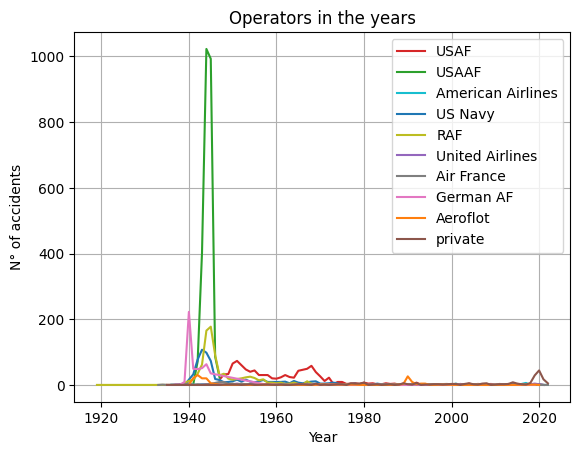

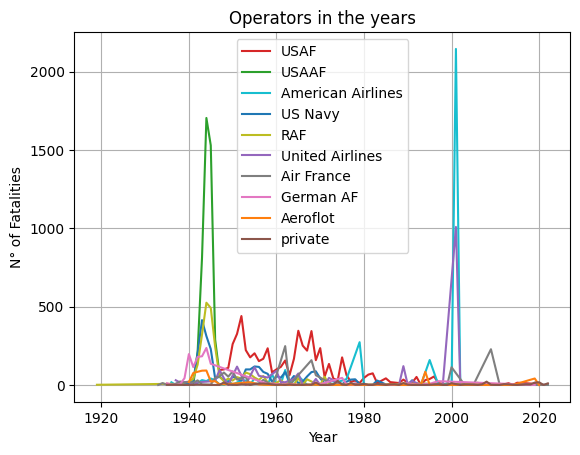

In [631]:
#Line chart with the trend in the years of the worst operators for accidents and fatalities
#same association operator-color as the bar chart (coerence)

fig, ax = plt.subplots()        #using subplots to plot multiple lines in the same chart in the same figure

for operator in colors_graph.keys():                                                                            #loop to plot the lines for each operator, color_graph used to have the same colors as the bar chart
    df_most_dis_per_y = df[df['operator'] == operator]                                                          #create the df with only the operator
    df_most_dis_per_y = df_most_dis_per_y.groupby(['operator', 'year']).agg(dis_per_y =('year', 'count'))       #grouping by operator and year and counting the number of accidents every year
    df_most_dis_per_y = df_most_dis_per_y.reset_index(level=1)                                                  #set the year as a column and only the operator as index
    #plot the line with the relative color
    ax = df_most_dis_per_y.plot(ax= ax, x='year', y='dis_per_y', kind='line', label=operator, color=colors_graph[operator])

plt.title("Operators in the years")
plt.xlabel('Year')
plt.ylabel('N° of accidents')
plt.legend()
plt.grid()
plt.show()


fig, ax = plt.subplots()

for operator in colors_graph.keys():
    df_most_fat_per_y = df[df['operator'] == operator]
    df_most_fat_per_y = df_most_fat_per_y.groupby(['operator', 'year']).agg(fat_per_y =('fatalities', 'sum'))   #grouping by operator and year and calculating the number of fatalities for every year
    df_most_fat_per_y = df_most_fat_per_y.reset_index(level=1)

    ax = df_most_fat_per_y.plot(ax=ax, x='year', y='fat_per_y', kind='line', label=operator, color=colors_graph[operator])

plt.title("Operators in the years")
plt.xlabel('Year')
plt.ylabel('N° of Fatalities')
plt.legend()
plt.grid()
plt.show()


In [632]:
best_op_dis = op_df.sort_values(by='N_accidents')
best_op_dis[:50].sort_values(by='N_fatalities' , ascending=True).head(20)

,N_accidents,N_fatalities,N_years,Fat_dis_ratio
operator,,,,
Oriental Air Bridge,1.0,0.0,1,0.0
Island Airlines Hawaii,1.0,0.0,1,0.0
Tursair,1.0,0.0,1,0.0
Huns Air,1.0,0.0,1,0.0
NJ Airlines,1.0,0.0,1,0.0
American Velodur Metal,1.0,0.0,1,0.0
Island Traders,1.0,0.0,1,0.0
Pearl Air,1.0,0.0,1,0.0
Intercontinental Oil Co.,1.0,0.0,1,0.0


#### Operator Insight 
As we can see in the bar chart the USAAF and USAF are the operators with most accidents and fatalities.
Theese two have to be considered as a single operator because are the Air Force of the US Army that was called "US Army Air Forces" and after the 1947 became "US Air Force".
The most numbers of accidents are due to situations that involve army air forces of different countries: USA (USAAF, USAF, US Navy), UK (RAF, Royal Air Force), Germany (German AF).
Looking at the time series of the accidents for the operators considered worst is clear that the highest numbers (peaks) come from the second world war period and from the 11/09/2001 (twin towers attack), especially for the fatalities.
Ultimately, from the findings of this analysis, the worst operators are: USAAF, USAF, US Navy, RAF, German AF, United Airlines, American Airlines, Air France, Aeroflot and private operators.

For the analysis of the best operators is shown above a list of operators that have the smallest numbers for accidents (minimum is 1, otherwise they wouldn't be in the dataset) and for fatalities (0, of course).

NB: it has to be considered that the analysis is made on a dataset of accidents, so a deeper view need to consider the total number of flights that an operator makes and the percentage of accidents in relation to all the flights made.

### for Type

In [633]:
uniq_type = list(df['type'].unique())
print('Different types of aircraft = ', len(uniq_type))

Different types of aircraft =  3189


In [634]:
types_df = pd.DataFrame()
types_df['N_fat'] = df.groupby(['type'])['fatalities'].sum()
types_df['N_acc'] = df['type'].value_counts()  
types_df.sort_values(by='N_fat', ascending=False).head(20)

,N_fat,N_acc
type,,
Douglas C-47A (DC-3),5780.0,1916
Douglas C-47 (DC-3),2676.0,669
Douglas C-47B (DC-3),2017.0,592
Boeing 767-223ER,1692.0,2
Tupolev Tu-154M,1600.0,34
DC-9-32,1441.0,67
Ilyushin Il-18V,1356.0,53
Lockheed C-130H Hercules,1271.0,73
Antonov An-26,1246.0,137


In [635]:
worst_type = types_df.sort_values(by='N_fat', ascending=False).index[:10]

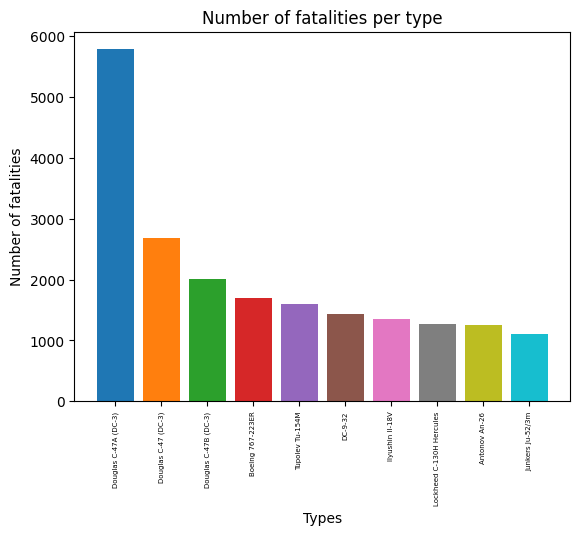

In [636]:
#Bar chart for the number of fatalities per operator (the worst)

labels = worst_type
colors_predefined = plt.rcParams['axes.prop_cycle'].by_key()['color']       #list of predefined colors
colors = dict(zip(labels, colors_predefined))                               #create a dictionary with the association operator-color

fatalities = types_df[types_df.index.isin(labels)]['N_fat'].sort_values(ascending=False)       ##series with the number of accidents for each operator

type_order = list(fatalities.index)
tuples = sorted(colors.items(), key=lambda x: type_order.index(x[0]))
colors_graph = dict(tuples)

plt.bar(fatalities.index, fatalities, color=colors_graph.values())
plt.xticks(fatalities.index, fontsize=5, rotation=90)
plt.title('Number of fatalities per type')
plt.xlabel('Types')
plt.ylabel('Number of fatalities')
plt.show()  

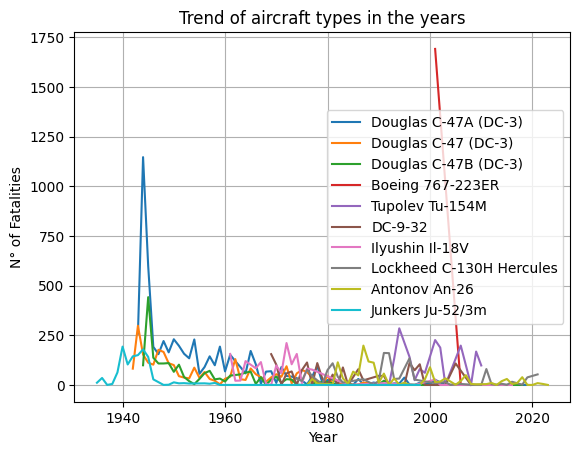

In [637]:
#Line chart with the trand in the years of the worst operators for fatalities
#same association operator-color as the bar chart (coerence)

fig, ax = plt.subplots()

for type_aircraft in colors_graph.keys():
    df_most_fat_per_y = df[df['type'] == type_aircraft]
    df_most_fat_per_y = df_most_fat_per_y.groupby(['type', 'year']).agg(fat_per_y =('fatalities', 'sum'))   #grouping by operator and year and calculating the number of fatalities for every year
    df_most_fat_per_y = df_most_fat_per_y.reset_index(level=1)

    ax = df_most_fat_per_y.plot(ax=ax, x='year', y='fat_per_y', kind='line', label=type_aircraft, color=colors_graph[type_aircraft])

plt.title("Trend of aircraft types in the years")
plt.xlabel('Year')
plt.ylabel('N° of Fatalities')
plt.legend()
plt.grid()
plt.show()


In the Types' analysis it was found that, in the same way as the Operators, the most deadly aircrafts are the ones involved in military situations. Infact the types that produced the most deaths are the Douglas C-47 series, used by the US and UK army (USAAF, USAF, RAF) with peaks in deaths during the 2nd World War. In the graphs are rapresented other army aircrafts as Junkers Ju-52/3m (Germany), Antonov An-26 (Soviet Union), Lockheed C-130H Hercules (US).

The others types rapresented are cargo aircraft meaning they transport passengers or goods.

The 4th most deadly type is the Boeing 767-223ER which had its deaths peak in the 11/09/2001, because was the type of the planes that crashed into the twin towers

### for Day of the week

In [638]:
days_dict = {1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu', 5: 'Fri', 6: 'Sat', 7: 'Sun'}

In [639]:
#create the df grouping by Day Of Week and calculating the frequencies of accidents and fatalities
dow_df = pd.DataFrame()
dow_df = df.groupby(['weekday']).agg(fat_mean = ('fatalities', 'mean'), dis_abs_freq = ('fatalities', 'count'))
dow_df.insert(0, 'days', dow_df.index.map(days_dict))   #insert the days of the week as the first column
dow_df['dis_rel_freq'] = df['weekday'].value_counts(normalize=True, dropna=True)

In [640]:
year_min = int(df['year'].min())
year_max = int(df['year'].max())
time_slot = [10, 4]

In [641]:
def colors_array (series_of_value, color_normal='tab:blue', color_max='tab:red'):
    '''
    Retun a color array with the same length of the input array
    The color of the element with the index_max is highlighted with a different color
    '''
    color_bar = color_normal
    index_max_1 = np.argmax(series_of_value)
    colors_bar = [color_normal] * len(series_of_value)    
    colors_bar[index_max_1] = color_max                    
    return colors_bar

,days,1919-1930,1931-1941,1942-1952,1953-1963,1964-1974,1975-1985,1986-1996,1997-2007,2008-2018,2019-2023
weekday,,,,,,,,,,,
1.0,Mon,14,102,819,335,446,348,413,352,357,131
2.0,Tue,11,109,928,379,453,374,399,357,311,123
3.0,Wed,21,82,883,396,460,390,418,375,342,124
4.0,Thu,10,85,874,362,493,415,418,401,344,114
5.0,Fri,15,262,888,374,496,408,402,376,341,139
6.0,Sat,18,112,866,310,456,342,367,309,288,118
7.0,Sun,11,108,773,290,360,294,273,252,288,104


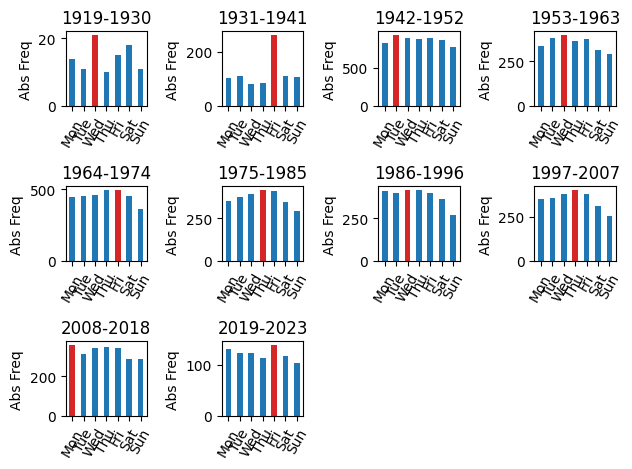

,days,1919-1945,1946-1971,1972-1997,1998-2023
weekday,,,,,
1.0,Mon,673,912,923,809
2.0,Tue,734,1020,935,755
3.0,Wed,684,1013,990,804
4.0,Thu,652,1060,978,826
5.0,Fri,846,1035,1001,819
6.0,Sat,742,916,846,682
7.0,Sun,661,783,683,626


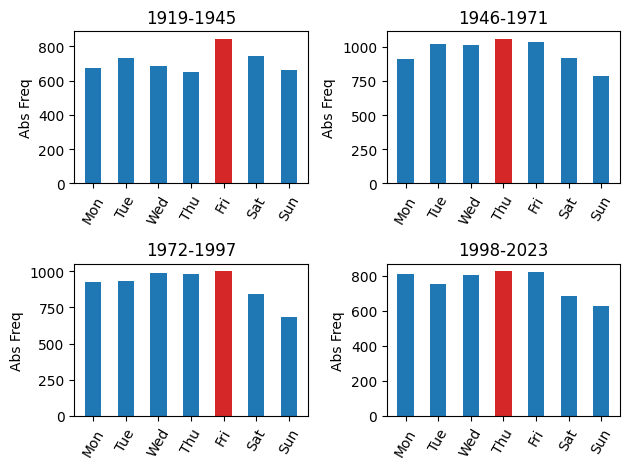

In [642]:
for t in time_slot:                                 #loop for every time interval we choose
    step = math.ceil((year_max-year_min)/t)
    dow_df_years = dow_df.copy().drop(columns=['fat_mean', 'dis_rel_freq', 'dis_abs_freq'])
    
    for i in range(year_min+1, year_max + 1, step):   #loop to create the df with the frequencies for each time interval
        
        if i == year_min +1:
            lower_limit = year_min
        else:
            lower_limit = i
            
        upper_limit = i + step
        
        if upper_limit > year_max:
            upper_limit = year_max + 1
            
        name_col = str(lower_limit) + '-' + str(upper_limit-1)
        df_filt = df[(df['year'] >= lower_limit) & (df['year'] < upper_limit)]
        dow_df_years[name_col] = df_filt['weekday'].value_counts(dropna=True)
    
    display(dow_df_years)    
    x = dow_df_years['days']    
    num_col = 1

    width = 0.5
    if t <= 4:                      #calculate the number of columns and rows for the subplot
        n_cols = 2                  #based on the number of time intervals
    else:
        n_cols = 4
    n_rows = math.ceil(t/n_cols)


    for i in range(1, t+1):                         #loop to create as much barcharts as the intervals        
        name_col = dow_df_years.columns[num_col]
        y1 = dow_df_years[name_col]
        colors_bar = colors_array(y1)
        
        plt.subplot(n_rows, n_cols, i)
        plt.title(str(name_col))
        plt.bar(x, y1, width, color=colors_bar)
        #plt.xlabel('Days')
        plt.ylabel('Abs Freq')
        plt.tick_params(axis='y')
        plt.tick_params(axis='x', rotation = 60)
        num_col += 1

    plt.grid
    plt.tight_layout()
    plt.show()

In [643]:
dow_df

,days,fat_mean,dis_abs_freq,dis_rel_freq
weekday,,,,
1.0,Mon,6.384396,2807,0.141704
2.0,Tue,7.384432,2942,0.147129
3.0,Wed,6.662122,3007,0.149137
4.0,Thu,5.862425,3002,0.150205
5.0,Fri,6.170581,3066,0.158108
6.0,Sat,6.736921,2657,0.136107
7.0,Sun,8.007752,2322,0.117609


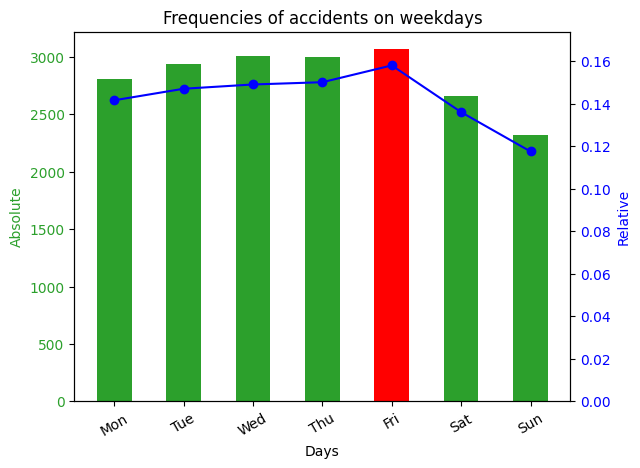

In [644]:
#Chart with frequencies of accidents on every day of the week
x = dow_df['days']
y1 = dow_df['dis_abs_freq']
y2 = dow_df['dis_rel_freq']
X_axis = np.arange(len(dow_df['days'])) 

width = 0.5

#Create the figure and the first axis
fig, ax1 = plt.subplots()

#Barchart for the absolute frequencies
color_norm = 'tab:green'
colors_bar = colors_array(y1, color_normal=color_norm, color_max='red')   
ax1.bar(x, y1, width, color=colors_bar, label='Absolute (Bar)')
ax1.set_xlabel('Days')
ax1.set_ylabel('Absolute', color = color_norm)
ax1.tick_params(axis='y', labelcolor=color_norm)
ax1.tick_params(axis='x', labelcolor='black', rotation = 30)

#Create the second axis sharing the x axis with ax1
ax2 = ax1.twinx()

#Linechart for the relative frequencies
color_line = 'blue'
ax2.plot(x, y2, color=color_line, marker='o', label='Relative (Line)')
ax2.set_ylabel('Relative', color=color_line)
ax2.tick_params(axis='y', labelcolor=color_line)
ax2.set_ylim([0, max(y2)*1.1])      #set the limits of the y_realtive axis to make it start 0


plt.title('Frequencies of accidents on weekdays')
plt.show()

Looking at the frequencies of accidents on weekdays, in the last graph (total of the entire range of time) we see that the highest frequency is on FRIDAY, both for absolute and relative freq.

If we consider different ranges of years, the weekday with the most frequent accidents differs based on size of the time ranges. This result is observable in the previous graphs with 4 and 10 time intervals.

### for Country

In [645]:
df_country = pd.DataFrame()
df_country['N_fatalities'] = df.groupby(['country'])['fatalities'].sum()
df_country['N_accidents'] = df['country'].value_counts()
df_country = df_country.reset_index()
df_country = df_country.sort_values(by='N_fatalities', ascending=False)

In [646]:
df_country.sort_values(by='N_fatalities', ascending=False).head(20)

,country,N_fatalities,N_accidents
218,USA,19305.0,4377
170,Russia,9973.0,1422
30,Brazil,3523.0,609
95,India,3505.0,700
73,France,3426.0,550
97,Indonesia,3360.0,437
46,Colombia,3325.0,457
12,Atlantic Ocean,2900.0,217
43,China,2870.0,514
190,Spain,2785.0,260


In [647]:
#dict to correct the names of the countries to have the same as in the df world 
dict_right_country_name = {
    'USA' : 'United States of America',
    'U.K.' : 'United Kingdom',
    'P.N. Guinea' : 'Papua New Guinea',
    'Czech Rep.' : 'Czechia',
    'Bosnia' : 'Bosnia and Herz.',
    'D.R. Congo' : 'Dem. Rep. Congo',
    'South Sudan' : 'S. Sudan',
    'Solomon Isl.' : 'Solomon Is.',
    'Eswatini' : 'eSwatini',
    'Cote d\'Ivoire' : 'Côte d\'Ivoire',	
    'Falkland Isl.' : 'Falkland Is.',
    'Western Sahara' : 'W. Sahara',
    'Trinidad & Tobago' : 'Trinidad and Tobago'
    
}

In [648]:
#apply the correction if country in dict_right_country_name
def right_country(old_name, diz=dict_right_country_name):
    try:
        new_name = diz[old_name]
        return new_name
    except:
        return old_name


In [649]:
df_country['country'] = df_country['country'].apply(right_country)

In [650]:
df_country.head(20)

,country,N_fatalities,N_accidents
218,United States of America,19305.0,4377
170,Russia,9973.0,1422
30,Brazil,3523.0,609
95,India,3505.0,700
73,France,3426.0,550
97,Indonesia,3360.0,437
46,Colombia,3325.0,457
12,Atlantic Ocean,2900.0,217
43,China,2870.0,514
190,Spain,2785.0,260


In [651]:
#get the df of all country to create the map
df_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
#merge my df_country with df of geopandas 
df_world_accidents = df_world.merge(df_country, how='left', left_on='name', right_on='country')

C:\Users\Tia\AppData\Local\Temp\ipykernel_12516\1903262940.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  df_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


In [652]:
#set Nan values for accident and fatalities to zero, to not have problem creating the map
df_world_accidents.fillna({'N_fatalities': 0}, inplace=True)
df_world_accidents.fillna({'N_accidents':0}, inplace=True)

In [653]:
#load the color map for the heat map 
orig_map = plt.colormaps['viridis']
#set the dark colors for higher numbers
reversed_map = orig_map.reversed()

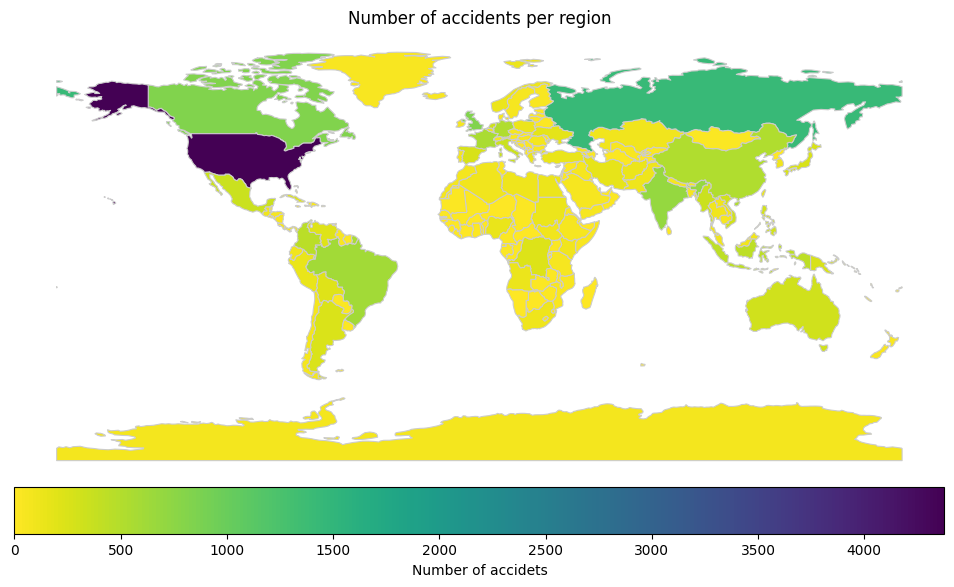

In [654]:
#create the world map
fig, ax = plt.subplots(figsize=(12, 8))
df_world_accidents.plot(column='N_accidents', cmap=reversed_map, linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, legend_kwds={"label": "Number of accidets","orientation": "horizontal", "pad": 0.01} )
ax.set_title('Number of accidents per region')
ax.set_axis_off()

plt.show()

The two countries with the higher numebers of accidents and fatalities are:
- 1st position United States of America 
- 2nd position Russia

### for Category

In [655]:
#dictionary for the categories desciption
dict_cat_def ={
    'A' : 'Accident', 
    'I' : 'Incident',
    'H' : 'Hijacking',
    'C' : 'Criminal occurrence (sabotage, shoot down)',
    'O' : 'Other occurrence (ground fire, sabotage)',
    'U' : 'Type of occurrence unknown',
    '1' : ', hull-loss',
    '2' : ', repairable damage'
}

In [656]:
def create_desctiption(cat_str):
    '''
    Take a string in input
    If an element of the str is included in dict keys
    Add to description the correspondent value
    Return the description
    '''
    descr = ''
    for el in cat_str:
        if el in dict_cat_def.keys():
            descr = descr + dict_cat_def[el]
    return descr

,cat,Accident,description
0,A1,17424,"Accident, hull-loss"
1,A2,2494,"Accident, repairable damage"
2,C1,1185,"Criminal occurrence (sabotage, shoot down), hull-loss"
3,H2,1052,"Hijacking, repairable damage"
4,O1,1035,"Other occurrence (ground fire, sabotage), hull-loss"
5,U1,571,"Type of occurrence unknown, hull-loss"
6,C2,84,"Criminal occurrence (sabotage, shoot down), repairable damage"
7,O2,65,"Other occurrence (ground fire, sabotage), repairable damage"
8,H1,42,"Hijacking, hull-loss"
9,I2,12,"Incident, repairable damage"


C:\Users\Tia\AppData\Local\Temp\ipykernel_12516\3086302077.py:9: FutureWarning: data_manager option is deprecated and will be removed in a future version. Only the BlockManager will be available.
  pd.reset_option('all')                          #reset the display options
C:\Users\Tia\AppData\Local\Temp\ipykernel_12516\3086302077.py:9: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.reset_option('all')                          #reset the display options


,cat,Accident
0,A1,17424
1,A2,2494
2,C1,1185
3,H2,1052
4,O1,1035
6,U1,571
5,Others,206


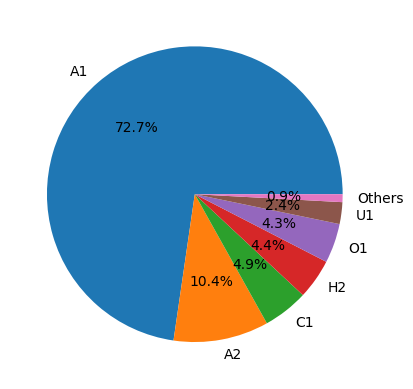

In [657]:
#create an aggregate df for the categories
df_cat = pd.DataFrame()
threshold = 200
df_cat['Accident'] = df.value_counts('cat', dropna=1)
df_cat.reset_index(inplace=True)
df_cat['description'] = df_cat['cat'].apply(create_desctiption)
pd.set_option('display.max_colwidth', None)     #to see all the description
display(df_cat)
pd.reset_option('all')                          #reset the display options

#create the df cat to make a pie plot, aggregate the rows with low values
df_cat_chart = df_cat.copy()
df_cat_chart['cat']= df_cat.apply(lambda row: 'Others' if row['Accident'] < threshold else row['cat'], axis=1)
df_cat_chart = df_cat_chart.groupby('cat', as_index=False).agg({'Accident': 'sum'}).sort_values('Accident', ascending=False)
display(df_cat_chart)
#Pie Chart of accidents' number per category
plt.pie(df_cat_chart['Accident'], labels=df_cat_chart['cat'], autopct='%1.1f%%', startangle=0)
plt.show()

The categories with the highest percentage are A1 and A2, so in the largest part of the accidents there was the total loss of the plane.
The descriptions are taken from the ASN web site.

Just for clarity:

an Accident is cosidered when:
- a) a person is fatally or seriously injured
- b) the aircraft sustains damage or structural failure
- c) the aircraft is missing or is completely inaccessible 

while an Incident is defined as: an occurrence, other than an accident, associated with the operation of an aircraft which affects or could affect (no need for damage or injuries) the safety of operation.

So an Accident is more dangerous than an Incident.

To understand better the definitions that differentiate Accident, Incident,... watch the standards used on [ASN](https://aviation-safety.net/database/legend.php)

### for Date

In [658]:
df_years = pd.DataFrame()
df_years['accidents'] = df['year'].value_counts()
df_years['fatalities'] = df.groupby(['year'])['fatalities'].sum()
df_years['fat_mean'] = df.groupby(['year'])['fatalities'].mean()
df_years.sort_index(inplace=True)

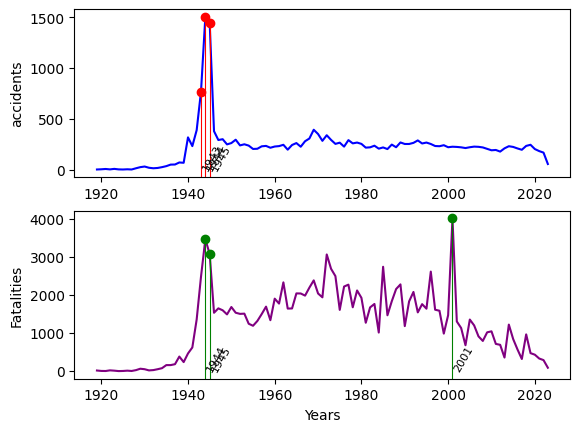

In [659]:
#Chart the accidents and fatalities over the years

#Set the series to have the maximum values of accidents and fatalitites
dis_max_values = df_years.nlargest(3, 'accidents')['accidents']
fat_max_values = df_years.nlargest(3, 'fatalities')['fatalities']
#set the series to plot
t = df_years.index
y1 = df_years['accidents']
y2 = df_years['fatalities']

def get_vertical_lines(ax, vert_values, color_line='red'):
    '''
    Create vertical lines, with markers at the top, in an existing axes from subplots
    As many lines as the elements of the vert_values array 
    '''
    for vline in vert_values.index:
        y_min, y_max= ax.get_ylim()
        y_end = vert_values[vline]
        y_max = (y_end - y_min) / (y_max - y_min)
        ax.axvline(x=vline, ymin=y_min, ymax=y_max, color=color_line, linestyle='-', linewidth=0.8)
        ax.plot(vline, y_end, marker='o', color=color_line)
        ax.text(vline, 0, int(vline), fontsize =8, rotation=60)

#plot the chart with subplots 
fig, axs = plt.subplots(2,1)

axs[0].plot(t, y1, color='blue')
get_vertical_lines(axs[0], dis_max_values, color_line='red')
axs[0].set_ylabel('accidents')

axs[1].plot(t, y2, color='purple')
get_vertical_lines(axs[1], fat_max_values, color_line='green')
axs[1].set_xlabel('Years')
axs[1].set_ylabel('Fatalities')

plt.show()

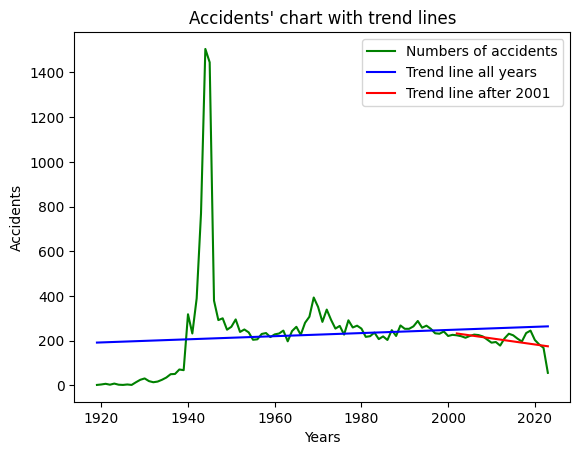

In [660]:
#Create a trend line for the number of accidents

#arrays of all data
t_arr = np.array(t)
y_arr = np.array(y1)
#arrays of the data after 2001
t_arr_post = np.array(df_years[df_years.index > 2001].index)
y_arr_post = np.array(df_years[df_years.index > 2001]['accidents'])

#calculate slope and intecept for the trend lines
slope, intercept = np.polyfit(t_arr, y_arr, 1)  #trend line of all period
slope_p, intercept_p = np.polyfit(t_arr_post, y_arr_post, 1)  #trend line after 2001

#Line chart of the accidents of the entire timelap
plt.plot(t, y1, 'g-', label='Numbers of accidents')

#Create the tred lines
plt.plot(t, slope * t + intercept, 'b-', label='Trend line all years')
plt.plot(t_arr_post, slope_p * t_arr_post + intercept_p, 'r-', label='Trend line after 2001')


plt.xlabel('Years')
plt.ylabel('Accidents')
plt.title('Accidents\' chart with trend lines')
plt.legend()

plt.show()

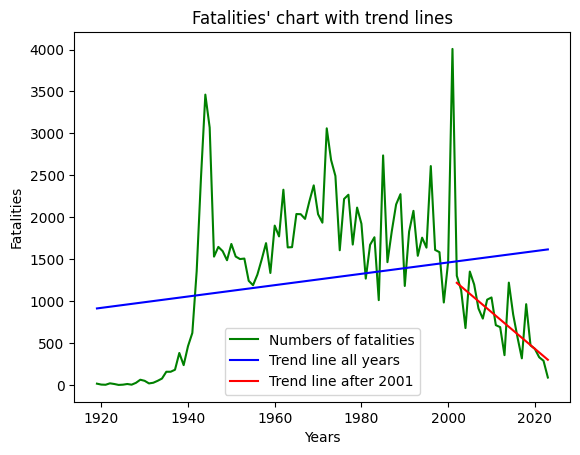

In [661]:
#Create a trend line for the number of fatalities

#arrays of all data
t_arr = np.array(t)
y_arr = np.array(y2)
#arrays of the data after 2001
t_arr_post = np.array(df_years[df_years.index > 2001].index)
y_arr_post = np.array(df_years[df_years.index > 2001]['fatalities'])

#calculate slope and intecept for the trend lines
slope, intercept = np.polyfit(t_arr, y_arr, 1)  #trend line of all period
slope_p, intercept_p = np.polyfit(t_arr_post, y_arr_post, 1)  #trend line after 2001

#Line chart of the fatalities of the entire timelap
plt.plot(t, y2, 'g-', label='Numbers of fatalities')

#Create the tred lines
plt.plot(t, slope * t + intercept, 'b-', label='Trend line all years')
plt.plot(t_arr_post, slope_p * t_arr_post + intercept_p, 'r-', label='Trend line after 2001')


plt.xlabel('Years')
plt.ylabel('Fatalities')
plt.title('Fatalities\' chart with trend lines')
plt.legend()

plt.show()

Over the years we can recognize that during the second world war there have been the highest number of accidents (especially in 1943, 1944, 1945), while for the numbers of fatalities the highest peak occurs on 2001 but immediately followed by the years 1944 and 1945.

The trend line over the all period analyzed (blue) has a positive slope both for accidents and fatalities.
From the trend line of accidents after the 2001 (red) we can see a decreasing trend both in accidents and fatalities.